In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/dataworld/My_learning/1. DA - DS/2. Course note/10. TensorFlow Developer Certificate 2022/LearnTDC2022/notebooks
!pwd

Mounted at /content/drive
/content/drive/MyDrive/dataworld/My_learning/1. DA - DS/2. Course note/10. TensorFlow Developer Certificate 2022/LearnTDC2022/notebooks
/content/drive/MyDrive/dataworld/My_learning/1. DA - DS/2. Course note/10. TensorFlow Developer Certificate 2022/LearnTDC2022/notebooks


# Transfer learning in CV

## Feature extraction (tensorflow hub)

In [ ]:
import os
import tensorflow as tf
import datetime
from tqdm.keras import TqdmCallback

In [ ]:
# datasets: bộ dữ liệu sử dụng 10% dữ liệu train của 10-food-class-all
data_folder = 'Datasets/10_food_classes_10_percent/'
data_folder = data_folder.strip(os.sep)
root_level = data_folder.count(os.sep)
for dirpath, dirnames, filenames in os.walk(data_folder):
    dir_level = dirpath.count(os.sep)
    print("|-----"*(dir_level - root_level), end = "")
    print(dirpath.split(os.sep)[-1], end = ": ")
    t = ""
    if len(dirnames) > 0:
        t+=f"{len(dirnames)} folders "
    if len(filenames) > 0 :
        t+=f"{len(filenames)} files "
    print(t)

10_food_classes_10_percent: 2 folders 1 files 
|-----test: 10 folders 
|-----|-----ice_cream: 250 files 
|-----|-----chicken_curry: 250 files 
|-----|-----steak: 250 files 
|-----|-----sushi: 250 files 
|-----|-----chicken_wings: 250 files 
|-----|-----grilled_salmon: 250 files 
|-----|-----hamburger: 250 files 
|-----|-----pizza: 250 files 
|-----|-----ramen: 250 files 
|-----|-----fried_rice: 250 files 
|-----train: 10 folders 
|-----|-----ice_cream: 75 files 
|-----|-----chicken_curry: 75 files 
|-----|-----steak: 75 files 
|-----|-----sushi: 75 files 
|-----|-----chicken_wings: 75 files 
|-----|-----grilled_salmon: 75 files 
|-----|-----hamburger: 75 files 
|-----|-----pizza: 75 files 
|-----|-----ramen: 75 files 
|-----|-----fried_rice: 75 files 


In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = data_folder + "/train"
test_dir = data_folder + "/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:", end = " ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:", end = " ")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images: Found 750 images belonging to 10 classes.
Testing images: Found 2500 images belonging to 10 classes.


In [ ]:
# setup log tensorboard

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [ ]:
# download pretrain model from tensorflow hub
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_model(model_url, num_classes=10):
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer, # use the feature extraction layer as the base
        layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
    ])
    return model

In [ ]:
# check the output of feature extraction transfer learning
feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/sayakpaul/distill_bit_r50x1_224_feature_extraction/1",
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)

### Resnet 50 V2 feature vector (hub)

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/sayakpaul/distill_bit_r50x1_224_feature_extraction/1"

resnet_model = create_model(resnet_url)
resnet_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ['accuracy'])

resnet_model.fit(train_data_10_percent, 
                 epochs=5,    
                 steps_per_epoch=len(train_data_10_percent),
                validation_data=test_data,
                validation_steps=len(test_data),
                verbose = 0,
                callbacks=[create_tensorboard_callback(dir_name="models/tensorflow_hub", experiment_name="resnet50V2"),
                          TqdmCallback()]) 

Saving TensorBoard log files to: models/tensorflow_hub/resnet50V2/20230502-131436


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-05-02 13:14:36.889454: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23500352  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,520,842
Trainable params: 20,490
Non-trainable params: 23,500,352
_________________________________________________________________


Số lượng params trainable là 20490 từ output layer do set `trainable=False` từ pretrain model

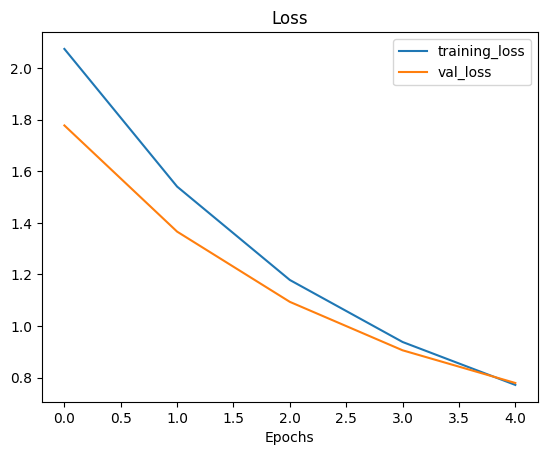

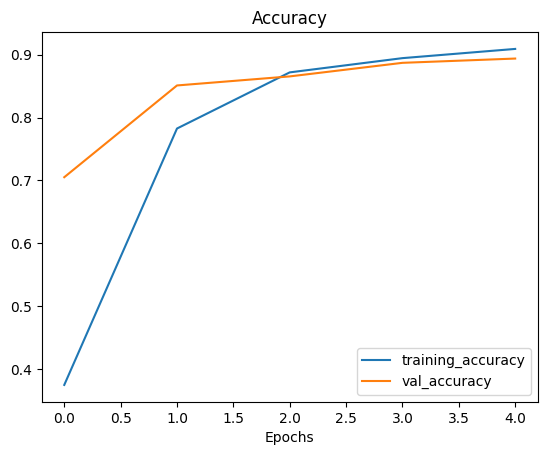

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(resnet_model.history)

### EfficientNetB6 feature vector (hub)

In [ ]:
# EfficientNetB6 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1"

eff_model = create_model(efficientnet_url)
eff_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ['accuracy'])

eff_model.fit(train_data_10_percent, 
                 epochs=5,    
                 steps_per_epoch=len(train_data_10_percent),
                validation_data=test_data,
                validation_steps=len(test_data),
                verbose = 0,
                callbacks=[create_tensorboard_callback(dir_name="models/tensorflow_hub", experiment_name="EfficientNetB6"),
                          TqdmCallback()]) 

eff_model.summary()

Saving TensorBoard log files to: models/tensorflow_hub/EfficientNetB6/20230502-142756


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2304)             40960136  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                23050     
                                                                 
Total params: 40,983,186
Trainable params: 23,050
Non-trainable params: 40,960,136
_________________________________________________________________


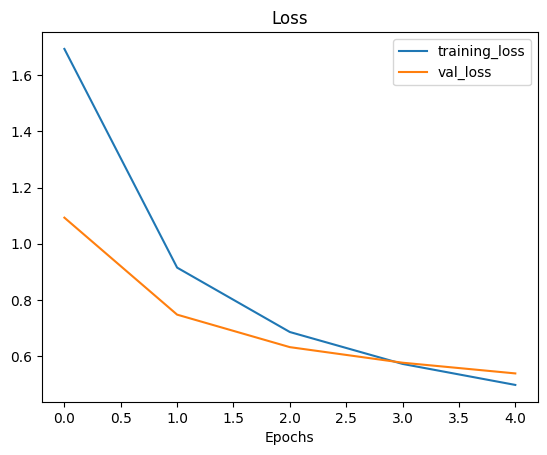

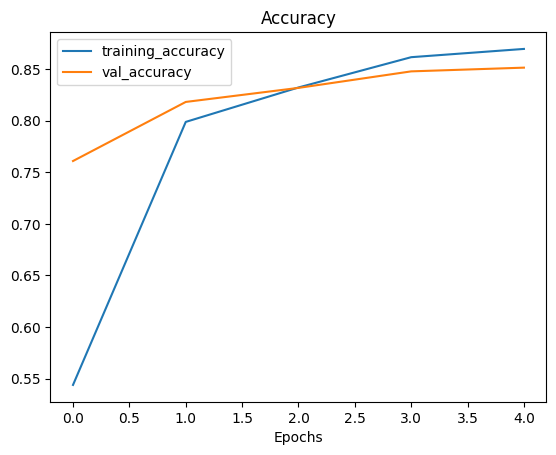

In [ ]:
plot_loss_curves(eff_model.history)

### upload experiments to tensorboard

In [ ]:
!tensorboard --logdir "models/tensorflow_hub/"

E0502 16:09:48.667149 8762030720 application.py:125] Failed to load plugin WhatIfToolPluginLoader.load; ignoring it.
Traceback (most recent call last):
  File "/Users/datkhong/miniconda3/lib/python3.10/site-packages/tensorboard/backend/application.py", line 123, in TensorBoardWSGIApp
    plugin = loader.load(context)
  File "/Users/datkhong/miniconda3/lib/python3.10/site-packages/tensorboard_plugin_wit/wit_plugin_loader.py", line 57, in load
    from tensorboard_plugin_wit.wit_plugin import WhatIfToolPlugin
  File "/Users/datkhong/miniconda3/lib/python3.10/site-packages/tensorboard_plugin_wit/wit_plugin.py", line 40, in <module>
    from tensorboard_plugin_wit._utils import common_utils
  File "/Users/datkhong/miniconda3/lib/python3.10/site-packages/tensorboard_plugin_wit/_utils/common_utils.py", line 17, in <module>
    from tensorboard_plugin_wit._vendor.tensorflow_serving.apis import classification_pb2
  File "/Users/datkhong/miniconda3/lib/python3.10/site-packages/tensorboard_plugi

## Fine Tunning

Trong fine-tuning, các weights từ pretrain model được unfreeze và train với số lượng layers lớn hơn so với feature extraction

Mặt khác, số lượng data cần cho fine-tuning cũng cần nhiều hơn so với feature extraction

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)



Timeline to build model:
1. Model1: small data + non augmentation data + feature extraction transfer learning
2. Model2: small data + augmentation data + feature extraction transfer learning (skip in notebook)
3. Model3: small data + augmentation data + fine-tuning transfer learning
4. Model4: all data + augmentation data + fine-tuning transfer learning

In [1]:
import tensorflow as tf
import os

### Model_1: 10_perc_train + non_aug + feature_extraction

In [2]:
# datasets: bộ dữ liệu sử dụng 10% dữ liệu train của 10-food-class-all
data_folder = 'Datasets/10_food_classes_10_percent/'
data_folder = data_folder.strip(os.sep)
root_level = data_folder.count(os.sep)
for dirpath, dirnames, filenames in os.walk(data_folder):
    dir_level = dirpath.count(os.sep)
    print("|-----"*(dir_level - root_level), end = "")
    print(dirpath.split(os.sep)[-1], end = ": ")
    t = ""
    if len(dirnames) > 0:
        t+=f"{len(dirnames)} folders "
    if len(filenames) > 0 :
        t+=f"{len(filenames)} files "
    print(t)

10_food_classes_10_percent: 2 folders 1 files 
|-----test: 10 folders 
|-----|-----ice_cream: 250 files 
|-----|-----chicken_curry: 250 files 
|-----|-----steak: 250 files 
|-----|-----sushi: 250 files 
|-----|-----chicken_wings: 250 files 
|-----|-----grilled_salmon: 250 files 
|-----|-----hamburger: 250 files 
|-----|-----pizza: 250 files 
|-----|-----ramen: 250 files 
|-----|-----fried_rice: 250 files 
|-----train: 10 folders 
|-----|-----ice_cream: 75 files 
|-----|-----chicken_curry: 75 files 
|-----|-----steak: 75 files 
|-----|-----sushi: 75 files 
|-----|-----chicken_wings: 75 files 
|-----|-----grilled_salmon: 75 files 
|-----|-----hamburger: 75 files 
|-----|-----pizza: 75 files 
|-----|-----ramen: 75 files 
|-----|-----fried_rice: 75 files 


#### Create input
Sử dụng [`tf.keras.utils.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) (thay vì sử dụng `ImageDataGenerator`) sẽ tạo đối tượng thuộc lớp `tf.data.Dataset` (thay vì một `generator`), hiệu quả hơn với dữ liệu lớn, tốc độ xử lý cao hơn `generator`.
Tuy nhiên ko có tuỳ chọn data augmentation, phải sử dụng data augmentation layer trong model

In [64]:
# Create training and test directories
train_dir = data_folder + "/train/"
test_dir = data_folder + "/test/"
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE) 
test_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                   shuffle = False)

Found 5860 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check the training data datatype
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
cnt = 0
for imgs , labels in train_data_10_percent.take(1):
    cnt+=1
print(cnt)
print(imgs.shape, labels.shape)

1
(32, 224, 224, 3) (32, 10)


2023-05-03 22:10:57.564253: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
# number of batches each epoch
len(train_data_10_percent)

24

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

#### Setup callbacks

In [ ]:
# process bar
# tqdm_cb = TqdmCallback()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# setup log tensorboard to compare multi experiments
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

log_tb = create_tensorboard_callback("models/fine_tuning_section", "10_percent_feature_extract")

Saving TensorBoard log files to: models/fine_tuning_section/10_percent_feature_extract/20230503_221631


In [ ]:
# modelCheckpoint to save model weights
# save weights only to faster and 
checkpoint_path = "models/fine_tuning_section/10_percent_feature_extract/checkpoint.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,                       # địa chỉ save model
    monitor= 'val_loss',      # chỉ số muốn tracking trong lúc train model
    verbose= 0,
    save_best_only = False,   # save the best monitor tracking only
    save_weights_only = True  # save weights only
)

In [ ]:
callbacks = [tqdm_cb, log_tb, checkpoint]

#### Modeling

In [ ]:
# 1. Create base model with tf.keras.applications
# set include_top = False because we will create own the output layer
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# 2. freeze the base model (pre-learned weights are remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = 'input_layer')

# 4. Normalize the inputs (need for ResNet or some others, but dont need for EfficientNet )
# 🤔 Note: As of writing, the EfficientNet models in the tf.keras.applications module do not require images 
# to be normalized (pixel values between 0 and 1) on input, where as many of the other models do. 
# inputs = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Passing inputs to the  base model
x = base_model(inputs)
print(f"check shape output the base model: {x.shape}") # (None, 7, 7, 1280)

# 6. Pooling the x để tổng hợp các most importance information, reduce number of computations và
# đưa layer về shape (batch_size, n) (2 chiều) --> phù hợp cho layers Dense output
# tf.keras.layers.GlobalAveragePooling2D() or tf.keras.layers.GlobalMaxPooling2D()
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print('Shape of GlobalAveragePooling2D output: ', x.shape) # (None, 1280)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less (25%) steps for validation so it's faster)
model_1.fit(train_data_10_percent,
             epochs=5,
             steps_per_epoch=len(train_data_10_percent),
             validation_data=test_data_10_percent,
             validation_steps=int(0.25 * len(test_data_10_percent)), 
             callbacks = [TqdmCallback(), log_tb, checkpoint], verbose = 0)

check shape output the base model: (None, 7, 7, 1280)
Shape of GlobalAveragePooling2D output:  (None, 1280)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

#### Evaluation

In [ ]:
model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 8s 96ms/step - loss: 0.5694 - accuracy: 0.8628


[0.569389820098877, 0.8628000617027283]

In [4]:
# plot curve
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

# plot_loss_curves(model_1.history)

#### check layers

In [ ]:
# model_1 layers
# only weights in output layer are trainable
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# base layer
# Check layers in our base model
nlayes = len(base_model.layers)
for layer_number, layer in enumerate(base_model.layers):
    if layer_number < 5 or layer_number > nlayes - 3:
        print(layer_number, layer.name)
    elif layer_number == nlayes - 3:
        print(". . .")
    

0 input_2
1 rescaling_2
2 normalization_1
3 rescaling_3
4 stem_conv_pad
. . .
236 top_bn
237 top_activation


> __EfficientNetB0__ có chứa layer rescaling tại layer thứ 2 (sau input layer) nên pretrain model này ko yêu cầu normalize data

#### feature vector

`tf.keras.layers.GlobalAveragePooling2D()` or `tf.keras.layers.GlobalMaxPooling2D()`

Các layer này giúp transform các 4D-tensor (output of non-top layer pretrain model) về 2D-tensor (phù hợp để connect với layer Dense output layer) bằng việc tính average/max across the inner-axes, thông qua đó:
- Vừa phù hợp với yêu cầu input shape của `Dense`
- Vừa trích lọc được các thông tin quan trọng
- Vừa giảm được chiều, từ đó giảm tính toán.

![](https://androidkt.com/wp-content/uploads/2021/06/Global-Avg-Pooling-2.png)

In [ ]:
# Ví dụ
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274686  -0.8426257   0.3194336 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.5397071   1.6994324 ]
   [ 0.28893656 -1.5066117  -0.26454768]]

  [[-0.5972242  -1.9171131  -0.6204413 ]
   [ 0.8504024  -0.4060477  -3.0258412 ]
   [ 0.9058465   0.29855984 -0.22561562]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772706]
   [ 0.24694408  0.20573746 -0.5256234 ]
   [ 0.32410023  0.02545409 -0.10638493]
   [-0.6369476   1.1603122   0.25073594]]

  [[-0.41728497  0.40125772 -1.4145442 ]
   [-0.5931858  -1.6617215   0.3356716 ]
   [ 0.1081563   0.23479682 -0.56668764]
   [-0.35819843  0.8869861   0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368647 -0.45840445 -0.28855982]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [ ]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368647, -0.45840445, -0.28855982]], dtype=float32)>

### Model_4: all_train + aug + fine-tuning

> __Note__: __Fine-tuning thường hoạt động tốt sau khi đã training feature-extraction model với 1 số lượng nhỏ epochs trước đó__ (for detail [check it out](https://keras.io/guides/transfer_learning/))

Sử dụng feature-extraction model để train trước 1 lượng nhỏ epochs data, sử dụng model đó, unfreeze 1 vài top layers và train tiếp tục với 1 vài epochs (có thể mở rộng và tiếp tục train cho đến khi đạt hiệu quả)

In [5]:
# datasets: bộ dữ liệu sử dụng all dữ liệu train của 10-food-class-all
data_folder = 'Datasets/10_food_classes_all_data/'
data_folder = data_folder.strip(os.sep)
root_level = data_folder.count(os.sep)
for dirpath, dirnames, filenames in os.walk(data_folder):
    dir_level = dirpath.count(os.sep)
    print("|-----"*(dir_level - root_level), end = "")
    print(dirpath.split(os.sep)[-1], end = ": ")
    t = ""
    if len(dirnames) > 0:
        t+=f"{len(dirnames)} folders "
    if len(filenames) > 0 :
        t+=f"{len(filenames)} files "
    print(t)

10_food_classes_all_data: 2 folders 
|-----test: 10 folders 
|-----|-----ice_cream: 250 files 
|-----|-----chicken_curry: 250 files 
|-----|-----steak: 250 files 
|-----|-----sushi: 250 files 
|-----|-----chicken_wings: 250 files 
|-----|-----grilled_salmon: 250 files 
|-----|-----hamburger: 250 files 
|-----|-----pizza: 250 files 
|-----|-----ramen: 250 files 
|-----|-----fried_rice: 250 files 
|-----train: 10 folders 
|-----|-----ice_cream: 750 files 
|-----|-----chicken_curry: 470 files 
|-----|-----steak: 750 files 
|-----|-----sushi: 470 files 
|-----|-----chicken_wings: 747 files 
|-----|-----grilled_salmon: 470 files 
|-----|-----hamburger: 470 files 
|-----|-----pizza: 469 files 
|-----|-----ramen: 514 files 
|-----|-----fried_rice: 750 files 


#### Create input
Sử dụng [`tf.keras.utils.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) (thay vì sử dụng `ImageDataGenerator`) sẽ tạo đối tượng thuộc lớp `tf.data.Dataset` (thay vì một `generator`), hiệu quả hơn với dữ liệu lớn, tốc độ xử lý cao hơn `generator`.

In [63]:
# Create training and test directories
train_dir = data_folder + "/train/"
test_dir = data_folder + "/test/"
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_all = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                            image_size=IMG_SIZE,
                                                            label_mode="categorical",
                                                            batch_size=BATCH_SIZE) 
test_data_all = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                           image_size=IMG_SIZE,
                                                           label_mode="categorical",
                                                            shuffle = False)

Found 5860 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Data Augmentation
Sử dụng `tf.keras.layers` để tạo data augmentation layer, mang lại hiệu quả hơn :
- Preprocessing images sẽ được sử lý thông qua GPU thay vì CPU, cho nên tốc độ sẽ nhanh hơn
> Note: Các dữ liệu dạng unstructured (images) sẽ phù hợp hơn khi xử lý trên GPU, con các dữ liệu có structured như 
- Augmentation data được xây dựng như 1 layer của model cho nên có thể export toàn bộ model (bao gồm cả lớp layer augmentation), và áp dụng các tham số augmentation được giữ nguyên
- __Data augmentation layers chỉ run khi training__, do đó, khi thực hiện việc prediction hoặc evaluation model thì layer này được tự động turn-off (Chỉ có `Resizing` và `Rescaling` là run in inference mode, còn lại các transformation khác là run in training mode)

__Một số data augmentation transformations được sử dụng phổ biến:__

- `RandomFlip` - flips image on horizontal or vertical axis. (lật ảnh ngang/dọc) _(training)_
- `RandomRotation` - randomly rotates image by a specified amount. (xoay ảnh) _(training)_
- `RandomZoom` - randomly zooms into an image by specified amount. (zoom ảnh) _(training)_
- `RandomHeight` - randomly shifts image height by a specified amount. (shift chiều cao) _(training)_
- `RandomWidth` - randomly shifts image width by a specified amount. (shift chiều rộng) _(training)_
- `Rescaling` - normalizes the image pixel values to be between 0 and 1 (normalization) _(inference)_
- `Resizing` - resize the image with specificly height and width. (resize image) _(inference)_
> `Rescaling` is required for some image models, but __EfficientNetB0__ (keras apps) is not required.

In [7]:
from tensorflow.keras import layers

In [8]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Resizing(224,224),  # (dont need to EfficientNetB0 because it's has)
    # layers.Rescaling(1./255) # (dont need to EfficientNetB0 because it's has)
], name = 'data_augmentation')

2023-05-05 19:55:00.100978: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Text(0.5, 1.0, 'Augmented image (1, 201, 249, 3)')

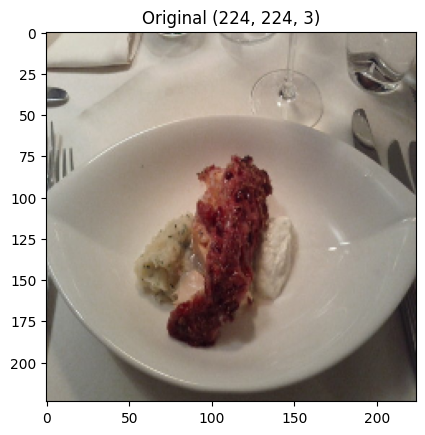

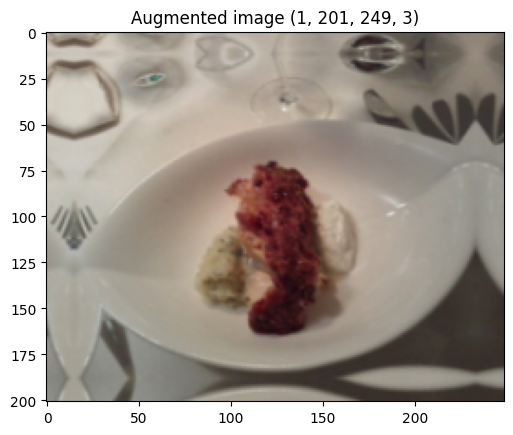

In [9]:
import matplotlib.image as mpimg
import random
img = [i[0] for i in train_data_all.take(1)][0][0]/255
plt.imshow(img)
plt.title(f"Original {img.shape}")
# plt.axis(False)

plt.figure()
augmented_img = data_aug(tf.expand_dims(img, axis=0))
plt.imshow(tf.squeeze(augmented_img))
plt.title(f"Augmented image {augmented_img.shape}" )
# plt.axis(False)

#### Setup callbacks

In [10]:
# process bar
# tqdm_cb = TqdmCallback()

In [11]:
# setup log tensorboard to compare multi experiments
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback



In [12]:
# modelCheckpoint to save model weights
# save weights only to faster and 



#### Modeling

- `training = False` (__inference mode__): layer run in predict/evaluate phrase, weights are not trainable and some regularization layers are not active., tương đương với `model.trainable = False`
- `training = True` (__training mode__): layer run in training time.

In [16]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape, name = 'input_layer')
x = data_aug(inputs)
x = base_model(x, training=False) # base model will run in inference mode (~ trainable = False)
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=["accuracy"])

##### fit with 10perc_train

train trước với model feature-extraction để làm base

In [17]:
from tqdm.keras import  TqdmCallback
import datetime

In [22]:
# Fit the model with 10% train data and we use less (25%) steps for validation so it's faster
initial_epochs = 5
tqdm_cb = TqdmCallback()
log_tb = create_tensorboard_callback("models/fine_tuning_section", "10_perc_fine_tune")
checkpoint_path = "models/fine_tuning_section/10_perc_fine_tune/checkpoint.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True)
model_3_his = model_3.fit(train_data_10_percent,
             epochs=initial_epochs,
             steps_per_epoch=len(train_data_10_percent),
             validation_data=test_data_10_percent,
             validation_steps=int(0.25 * len(test_data_10_percent)), 
             callbacks = [tqdm_cb, log_tb, checkpoint], verbose = 0)
tf.saved_model.save(model_3, "models/fine_tuning_section/10_perc_fine_tune/endmodel")
model_3.summary()

INFO:tensorflow:Assets written to: models/fine_tuning_section/10_perc_fine_tune/endmodel/assets


INFO:tensorflow:Assets written to: models/fine_tuning_section/10_perc_fine_tune/endmodel/assets


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [23]:
# evaluation
model_3_eval = model_3.evaluate(test_data_10_percent)
model_3_eval

79/79 [==============================] - 11s 131ms/step - loss: 0.6249 - accuracy: 0.8516


[0.6248779892921448, 0.8516000509262085]

In [ ]:
# load model from checkpoint
model_3.load_weights(checkpoint_path)

model_3_cp_eval = model_3.evaluate(test_data_10_percent)

import numpy as np
np.isclose(model_3_eval, model_3_cp_eval)

79/79 [==============================] - 34s 421ms/step - loss: 0.3378 - accuracy: 0.8928


array([ True,  True])

In [37]:
def plot_loss_curves(*history, break_epoch = []):
    break_epoch = [break_epoch] if not isinstance(break_epoch, list) else break_epoch
    all_his = {i:[] for i in history[0].keys()}
    for his in history:
        for k in his.keys():
            all_his[k] += his[k]
    train_res = [i for i in all_his.keys() if not i.startswith("val_")]
    valid_res = [i for i in all_his.keys() if i.startswith("val_")]
    epochs = range(1,len(all_his['loss'])+1)
    n = len(train_res)
    plt.figure(figsize = (10*n, 5))
    for i, m in enumerate(train_res):
        plt.subplot(1, n+1, i+1)
        plt.plot(epochs, all_his[m], label='training_'+m)
        if ("val_"+m) in valid_res:
            plt.plot(epochs, all_his["val_"+m], label="val_"+m)
        for idx, bre in enumerate(break_epoch):
            plt.plot([bre, bre], plt.ylim(), label='Start-point-{}'.format(idx))
        plt.title(m)
        plt.xlabel('Epochs')
        plt.legend()

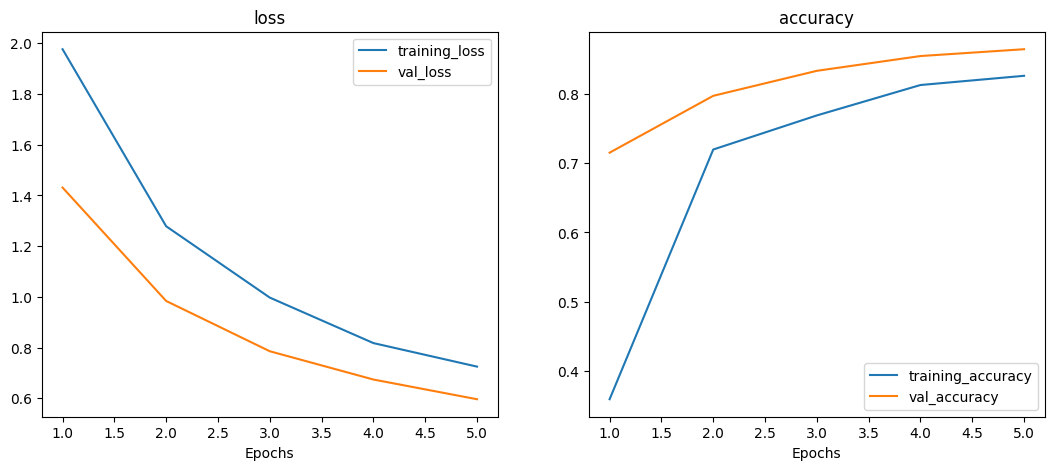

In [38]:
plot_loss_curves(model_3_his.history)

##### fine-tuning with all_train

In [27]:
# check variable trainable in base model
len(base_model.trainable_variables)

0

- Không có nguyên tắc về số lượng layers được unfreeze, thông thường, nếu có càng ít data thì số lượng unfreeze 1 lần càng ít, và dần dần unfreeze cho đến khi đạt hiệu quả
- Sau mỗi lần hiệu chỉnh lại model, cần phải __recompile model__

In [28]:
# set top-10 layers of base model to trainable = True
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
# recompile model
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [29]:
list_trainable = []
for layer in model_3.layers[2].layers:
    list_trainable.append(layer.trainable)

list_trainable.count(True)

10

In [30]:
# check variable trainable in model
len(model_3.trainable_variables)

12

In [31]:
# Fit the fine-tune model with 10% train data and we use less (25%) steps for validation so it's faster
finetune_epochs = initial_epochs + 5
tqdm_cb = TqdmCallback()
log_tb = create_tensorboard_callback("models/fine_tuning_section", "10_perc_top10_fine_tune")
checkpoint_path = "models/fine_tuning_section/10_perc_top10_fine_tune/checkpoint.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True)
model_3_finetune_his = model_3.fit(train_data_all,
                            epochs=finetune_epochs,
                            initial_epoch=model_3_his.epoch[-1]+1,
                            steps_per_epoch=len(train_data_all),
                            validation_data=test_data_all,
                            validation_steps=int(0.25 * len(test_data_all)), 
                            callbacks = [tqdm_cb, log_tb, checkpoint], verbose = 0)

tf.saved_model.save(model_3, "models/fine_tuning_section/10_perc_top10_fine_tune/endmodel")
model_3.summary()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Saving TensorBoard log files to: models/fine_tuning_section/10_perc_top10_fine_tune/20230505_201311


INFO:tensorflow:Assets written to: models/fine_tuning_section/10_perc_top10_fine_tune/endmodel/assets


INFO:tensorflow:Assets written to: models/fine_tuning_section/10_perc_top10_fine_tune/endmodel/assets


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [32]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_3.evaluate(test_data_all)

79/79 [==============================] - 50s 631ms/step - loss: 0.2978 - accuracy: 0.9020


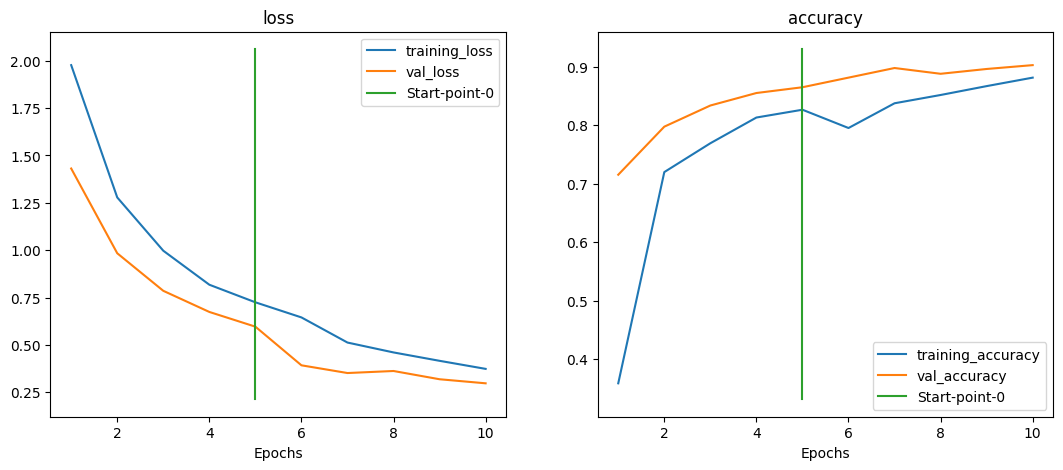

In [39]:
plot_loss_curves(model_3_his.history, model_3_finetune_his.history, break_epoch=initial_epochs)

### Scaling up

In [79]:
# true labels
y_true = []
for _ , label in test_data_all.unbatch():
    y_true.append(tf.argmax(label).numpy())

# predict labels
y_pred_prob = model_3.predict(test_data_all)
y_pred = y_pred_prob.argmax(axis = 1)

79/79 [==============================] - 39s 487ms/step


#### Confusion matrix

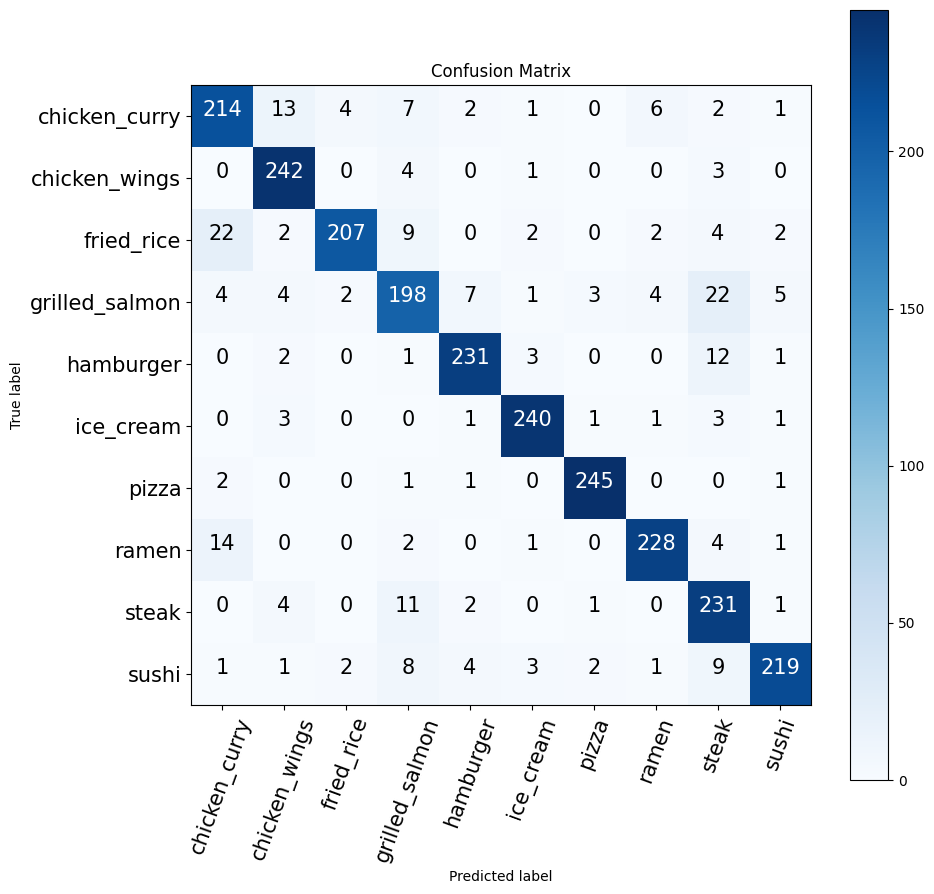

In [67]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

    Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                      y_pred=y_preds, # predicted labels
                      classes=class_names, # array of class label names
                      figsize=(15, 15),
                      text_size=10)
    """  
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")
        
make_confusion_matrix(y_true, y_pred, test_data_all.class_names)

#### f1-score

In [73]:
from sklearn.metrics import f1_score
import pandas as pd

<Axes: ylabel='classname'>

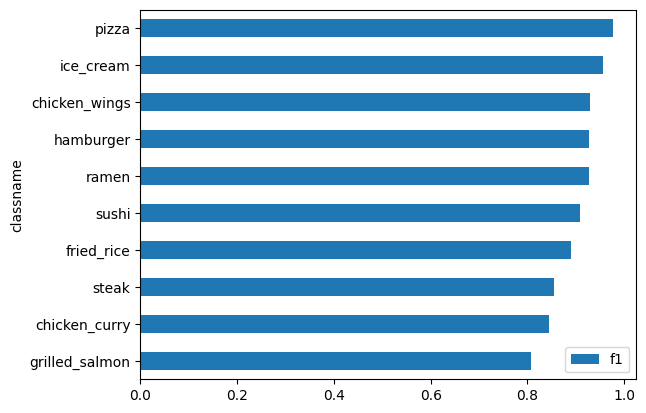

In [78]:
report = pd.DataFrame({'classname':test_data_all.class_names,'f1':f1_score(y_true, y_pred, average = None)})
report.sort_values('f1').set_index('classname').plot(kind="barh")

#### Find the most wrong prediction

In [85]:
pred_df = pd.DataFrame({"img_path": test_data_all.file_paths,
                        "y_true": y_true,
                        "y_pred": y_pred,
                        "pred_conf": y_pred_prob.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [test_data_all.class_names[i] for i in y_true],
                        "y_pred_classname": [test_data_all.class_names[i] for i in y_pred]}) 
wrong_pred = pred_df[pred_df['y_true']!=pred_df['y_pred']].sort_values('pred_conf', ascending =False)
wrong_pred

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
1602,Datasets/10_food_classes_all_data/test/pizza/2...,6,4,0.990422,pizza,hamburger
44,Datasets/10_food_classes_all_data/test/chicken...,0,2,0.985928,chicken_curry,fried_rice
160,Datasets/10_food_classes_all_data/test/chicken...,0,1,0.985873,chicken_curry,chicken_wings
951,Datasets/10_food_classes_all_data/test/grilled...,3,8,0.984870,grilled_salmon,steak
1093,Datasets/10_food_classes_all_data/test/hamburg...,4,5,0.979811,hamburger,ice_cream
...,...,...,...,...,...,...
2299,Datasets/10_food_classes_all_data/test/sushi/1...,9,8,0.300828,sushi,steak
168,Datasets/10_food_classes_all_data/test/chicken...,0,3,0.295611,chicken_curry,grilled_salmon
1176,Datasets/10_food_classes_all_data/test/hamburg...,4,9,0.268256,hamburger,sushi
216,Datasets/10_food_classes_all_data/test/chicken...,0,8,0.264306,chicken_curry,steak


In [157]:
import matplotlib.image as mpimg
def plot_image(df, ind = None, n_img = 1):
    if ind is not None:
        df_sample = df.iloc[ind].reset_index(drop = True)
        num = len(ind)
    else:
        df_sample = df.sample(n = n_img).reset_index(drop = True)
        num = n_img
    rows = (num+3)//4
    cols = 4 if (rows > 1) else min(4, num)
    fig = plt.figure(figsize=(15*rows, 15*cols),layout = 'tight')
    for i, row in df_sample.iterrows():
        color = "green" if row['y_true'] == row['y_pred'] else "red"
        plt.subplot(rows, cols, i+1)
        plt.imshow(mpimg.imread(row['img_path']))
        plt.axis(False)
        plt.title("Pred: {} {:2.0f}% (True: {})".format(row['y_pred_classname'], 
            100*row['pred_conf'], row['y_true_classname']), color=color)
    plt.tight_layout()
    plt.show()

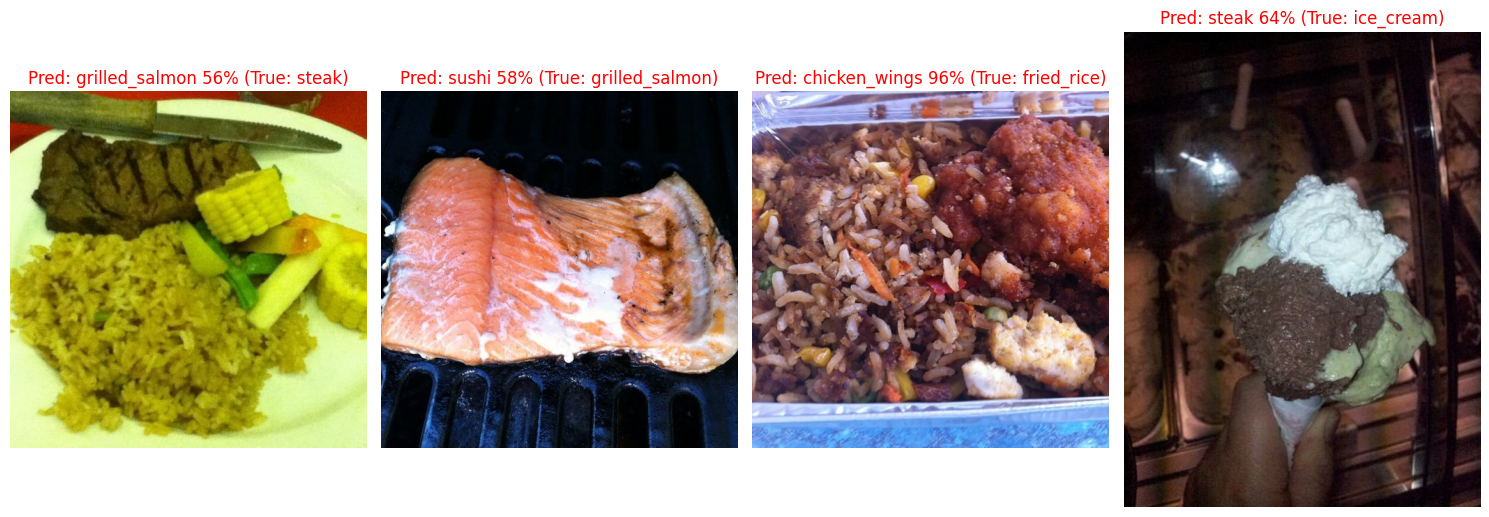

In [159]:
plot_image(wrong_pred, n_img = 4)

Visualize những image có xác suất dự đoán sai cao nhất giúp hình dung được dữ liệu và khả năng học của model
- __Có thể một số image được đánh nhãn sai ?__ từ những prediction sai, có thể lật ngược lại là image bị đánh label sai. Trong TH này, model có thể cải thiện labels trong dataset, và có khả năng make model tốt hơn trong tương lai ( việc này được đề cập là [active learning](https://blog.scaleway.com/active-learning-some-datapoints-are-more-equal-than-others/))
- __Có cần phải get more data không ?__ Một số class nhất định đang bị predict kém, một ít tưởng tốt là lấy thêm sample cho class đó và train 